# image controller

test list
2134
2198

In [1]:
box = (640,417,537,255)  


In [1]:
from my_tools.control import ImageController
controller = ImageController()

no function apply using default function


In [2]:
controller.run()

# model test


640-1280 is good
1449.jpg

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# # Load model directly
# from transformers import AutoImageProcessor, SegformerForSemanticSegmentation

# processor = AutoImageProcessor.from_pretrained("nvidia/segformer-b0-finetuned-cityscapes-640-1280",return_tensors="pt")
# model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-cityscapes-640-1280")

## segformer hugging face

In [10]:
# custom preprocess
from torchvision import transforms

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

custom_process = transforms.Compose([

    transforms.ToTensor(),
    # transforms.Resize((512,1024)),
    transforms.Normalize(mean = mean,std= std)

])


In [13]:
from seg.seg_utils import HF_segFormermodel

# model_repo = "nvidia/segformer-b0-finetuned-cityscapes-768-768"
# model_repo = "nvidia/segformer-b0-finetuned-cityscapes-512-1024"
# model_repo = "nvidia/segformer-b0-finetuned-cityscapes-640-1280"
model_repo = "nvidia/segformer-b1-finetuned-cityscapes-1024-1024"


# seg_model = HF_segFormermodel(model_repo,custom_processor=custom_process)
seg_model = HF_segFormermodel(model_repo)

using  cuda


In [14]:
seg_model.model.device

device(type='cuda', index=0)

In [6]:
seg_model.processor

SegformerImageProcessor {
  "_valid_processor_keys": [
    "images",
    "segmentation_maps",
    "do_resize",
    "size",
    "resample",
    "do_rescale",
    "rescale_factor",
    "do_normalize",
    "image_mean",
    "image_std",
    "do_reduce_labels",
    "return_tensors",
    "data_format",
    "input_data_format"
  ],
  "do_normalize": true,
  "do_reduce_labels": false,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "SegformerImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 512,
    "width": 512
  }
}

In [15]:
import cv2
def seg_wraper(img,crop_box):
    y1,y2, x1,x2 = crop_box
    img = img[y1:y2, x1:x2]
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    preds, _ = seg_model.predict([img],upsampling=True)
    # raise Exception("hi")

    # segs = seg_model.get_seg_image(preds)
    
    # return segs

    overlays = seg_model.get_seg_overlay([img],preds) 
    return overlays

# controller.apply_processor(seg_wraper)
controller.process = seg_wraper

In [16]:
controller.run()

In [17]:
import cv2

img1 = cv2.imread("data/raw_4cams/front/3800.jpg")
img2 = cv2.imread("data/raw_4cams/left/1380.jpg")
img3 = cv2.imread("data/raw_4cams/right/1000.jpg")

In [20]:

img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
preds, _ = seg_model.predict([img1],upsampling=True)
# raise Exception("hi")

# segs = seg_model.get_seg_image(preds)

# return segs

overlays = seg_model.get_seg_overlay([img1],preds) 


In [12]:
img1.shape

(720, 1280, 3)

In [24]:
list_tensor = [test_transform(im) for im in [img1,img2,img3]]


In [25]:
batch_tensor = torch.stack(list_tensor, dim=0)

In [26]:
batch_tensor.shape

torch.Size([3, 3, 1024, 512])

In [32]:
batch_tensor = batch_tensor.to(device)

In [10]:
inputs = seg_model.processor([img1,img2,img3],return_tensors="pt")["pixel_values"].to(device)

In [10]:
inputs.shape

torch.Size([3, 3, 512, 512])

In [12]:
with torch.no_grad():

    logits = seg_model.model(pixel_values = inputs).logits

In [13]:
logits.shape

torch.Size([3, 19, 128, 128])

In [15]:
pred = logits.argmax(dim=1).cpu()
pred.shape

torch.Size([3, 128, 128])

In [21]:
img = cv2.resize(img1,(pred[0].shape[0],pred[0].shape[1]))

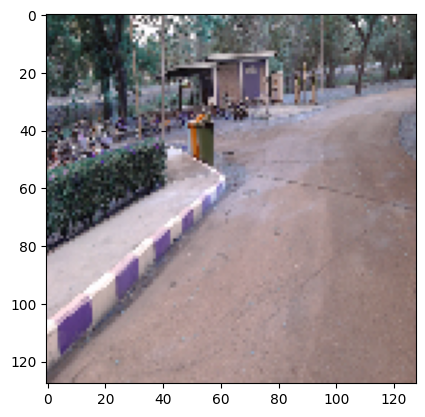

In [22]:
plt.imshow(img)

In [20]:
from torch import nn
upsampled_logits = nn.functional.interpolate(
    logits,
    size=img1.shape[:-1], # (height, width)
    mode='bilinear',
    align_corners=False
)

In [25]:
upsampled_logits.shape

torch.Size([3, 19, 720, 1280])

In [21]:
pred = upsampled_logits.argmax(dim=1).cpu()

In [23]:
pred[0].shape

torch.Size([720, 1280])

In [ ]:
def sidewalk_palette():
        """Sidewalk palette that maps each class to RGB values."""
        return [
            [155, 155, 155],
            [216, 82, 24],
            [255, 255, 0],
            [125, 46, 141],
            [118, 171, 47],
            [161, 19, 46],
            [255, 0, 0],
            [0, 128, 128],
            [190, 190, 0],
            [0, 255, 0],
            [0, 0, 255],
            [170, 0, 255],
            [84, 84, 0],
            [84, 170, 0],
            [84, 255, 0],
            [170, 84, 0],
            [170, 170, 0],
            [170, 255, 0],
            [255, 84, 0],
            [255, 170, 0],
            [255, 255, 0],
            [33, 138, 200],
            [0, 170, 127],
            [0, 255, 127],
            [84, 0, 127],
            [84, 84, 127],
            [84, 170, 127],
            [84, 255, 127],
            [170, 0, 127],
            [170, 84, 127],
            [170, 170, 127],
            [170, 255, 127],
            [255, 0, 127],
            [255, 84, 127],
            [255, 170, 127],
        ]

def get_seg_overlay(images, segs):
    imgs=[]
    for i in range(len(images)):
        color_seg = np.zeros((segs[i].shape[0], segs[i].shape[1], 3), dtype=np.uint8) # height, width, 3
        palette = np.array(sidewalk_palette())
        for label, color in enumerate(palette):
            color_seg[segs[i] == label, :] = color

        # Show image + mask
        img = np.array(images[i]) * 0.5 + color_seg * 0.5
        imgs.append(img.astype(np.uint8))

    return imgs

In [43]:
overlays = get_seg_overlay([img1,img2,img3],pred)

In [45]:
import cv2 
for i,overlay in enumerate(overlays):
    name = f"test{i}"
    cv2.imshow(name,overlay)

cv2.waitKey(0)
cv2.destroyAllWindows()

In [14]:
batch_tensor = np.stack([img1,img2,img3], axis=0)

In [16]:
batch_tensor.shape

(3, 720, 1280, 3)

In [ ]:
seg,overlay,logits = seg_model.predict(batch_tensor)

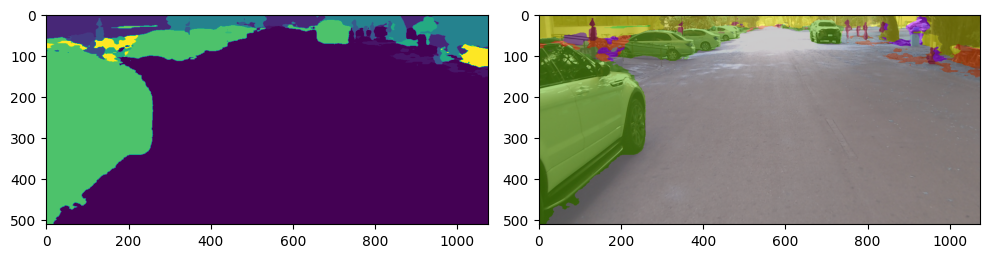

In [21]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,2,figsize=(10, 30))
ax[0].imshow(pred)
ax[1].imshow(overlayed)

plt.tight_layout()  # Optional: Adjust subplot parameters to give specified padding
plt.show()


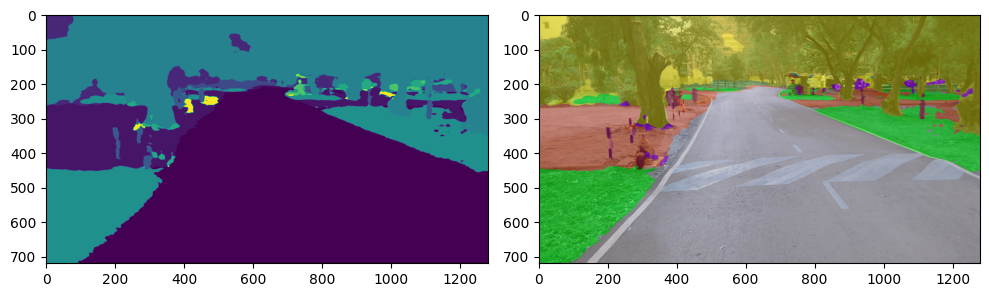

In [9]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,2,figsize=(10, 30))
ax[0].imshow(pred)
ax[1].imshow(overlayed)

plt.tight_layout()  # Optional: Adjust subplot parameters to give specified padding
plt.show()


## mask2former hugging face

In [16]:
import requests
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation

# Load Mask2Former model and image processor
repo = "facebook/mask2former-swin-large-mapillary-vistas-semantic"
processor = AutoImageProcessor.from_pretrained(repo)
model = Mask2FormerForUniversalSegmentation.from_pretrained(repo)
model.to(device)


Mask2FormerForUniversalSegmentation(
  (model): Mask2FormerModel(
    (pixel_level_module): Mask2FormerPixelLevelModule(
      (encoder): SwinBackbone(
        (embeddings): SwinEmbeddings(
          (patch_embeddings): SwinPatchEmbeddings(
            (projection): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
          )
          (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (encoder): SwinEncoder(
          (layers): ModuleList(
            (0): SwinStage(
              (blocks): ModuleList(
                (0-1): 2 x SwinLayer(
                  (layernorm_before): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
                  (attention): SwinAttention(
                    (self): SwinSelfAttention(
                      (query): Linear(in_features=192, out_features=192, bias=True)
                      (key): Linear(in_features=192, out_features=192, bias=True)
                     

In [12]:
import cv2

img1 = cv2.imread("data/raw_4cams/front/263.jpg")
img2 = cv2.imread("data/raw_4cams/front/3248.jpg")
img3 = cv2.imread("data/raw_4cams/right/1000.jpg")
img4 = cv2.imread("data/raw_4cams/front/1817.jpg")
img5 = cv2.imread("data/raw_4cams/front/1810.jpg")

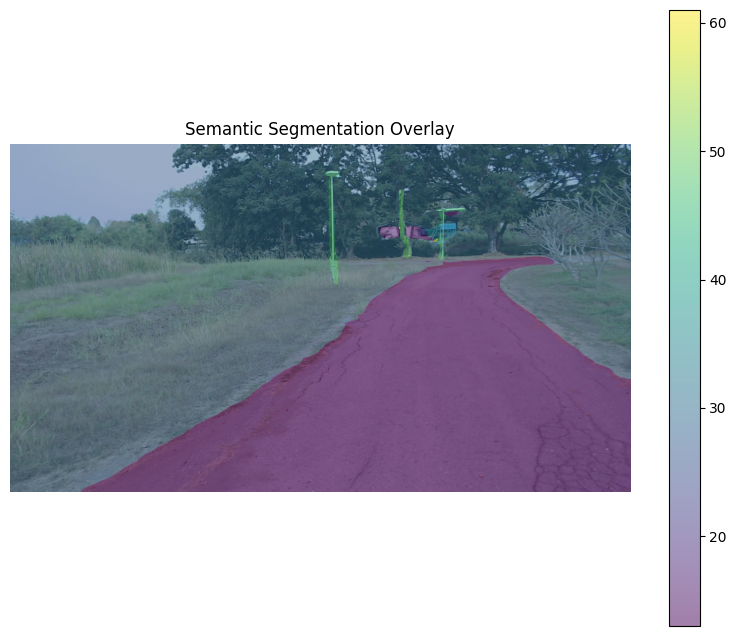

In [21]:
# Load an image from URL
images = [cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)]

# Preprocess the image
inputs = processor(images=images, return_tensors="pt").to(device)

# Perform inference
with torch.no_grad():
    outputs = model(**inputs)

# Post-process to get predicted semantic map
predicted_semantic_map = processor.post_process_semantic_segmentation(outputs, target_sizes=[images[0].shape[:-1]])[0]

# Convert predicted semantic map to a numpy array
predicted_semantic_map_np = predicted_semantic_map.cpu().numpy()

# Visualize the original image with overlay of semantic segmentation
plt.figure(figsize=(10, 8))

# Plot the original image
plt.imshow(images[0])
plt.axis('off')

# Overlay the semantic segmentation on the original image
plt.imshow(predicted_semantic_map_np, alpha=0.5, cmap='viridis')  # Adjust alpha for transparency
plt.colorbar()  # Show colorbar for semantic classes

# Add a title
plt.title("Semantic Segmentation Overlay")

# Show the plot
plt.show()


In [3]:
import requests
import matplotlib.pyplot as plt
from transformers import pipeline
import torch

segmenter = pipeline(
    "image-segmentation",
    model="facebook/mask2former-swin-large-cityscapes-semantic",
    device=0 if torch.cuda.is_available() else -1  # Use GPU if available
)

In [9]:
from PIL import Image
pil_image = Image.fromarray(img1)
results = segmenter(pil_image)

`label_ids_to_fuse` unset. No instance will be fused.


In [10]:
results

[{'score': 0.948429,
  'label': 'sky',
  'mask': <PIL.Image.Image image mode=L size=1280x720>},
 {'score': 0.933613,
  'label': 'building',
  'mask': <PIL.Image.Image image mode=L size=1280x720>},
 {'score': 0.999472,
  'label': 'road',
  'mask': <PIL.Image.Image image mode=L size=1280x720>},
 {'score': 0.999346,
  'label': 'pole',
  'mask': <PIL.Image.Image image mode=L size=1280x720>},
 {'score': 0.999667,
  'label': 'terrain',
  'mask': <PIL.Image.Image image mode=L size=1280x720>},
 {'score': 0.999889,
  'label': 'vegetation',
  'mask': <PIL.Image.Image image mode=L size=1280x720>}]

In [11]:
import numpy as np

masks = [result['mask'] for result in results]
# Convert PIL masks to numpy arrays
masks = [np.array(mask) for mask in masks]


In [13]:
color=sidewalk_palette()

In [24]:
color[0]

[155, 155, 155]

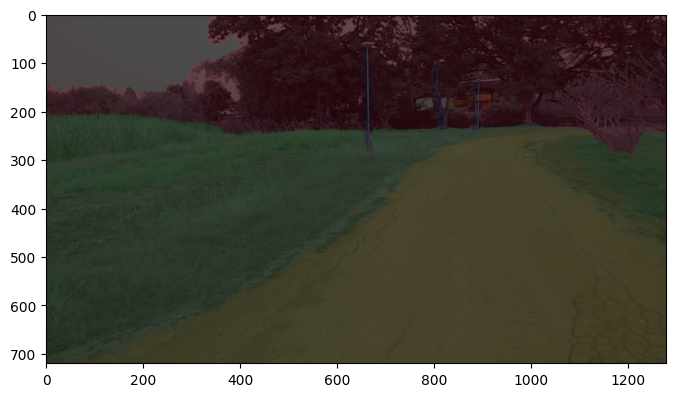

In [16]:
import matplotlib.pyplot as plt

# Display the original image
plt.figure(figsize=(8, 6))
plt.imshow(pil_image)

# Overlay each mask on the image
for i, result in enumerate(results):
    mask = masks[i]
    label = result['label']
    # Create a mask color for each class
    mask_color = np.zeros_like(pil_image)
    mask_color[mask == 255] = color[i] # Assuming RGB image

    # Display the mask overlay
    plt.imshow(mask_color, alpha=0.2)  # Adjust alpha for transparency

    # Show the class label as the plot title
    # plt.title(f"Class: {label}")
    # plt.axis('off')
plt.show()


## onnx

In [29]:
import onnx

# Load the ONNX model
onnx_model = onnx.load('seg/tao_model/pretrained_segformer_cityscapes_deployable_fan_tiny_hybrid_v1.0/cityscapes_fan_tiny_hybrid_224.onnx')



In [32]:
onnx.checker.check_model(onnx_model)

In [31]:
onnx_model.graph.input[0].type.tensor_type.shape.dim[0].dim_value

0

In [ ]:
# Modify the input shape to accept batch size 3
input_shape = [3, 3, 224, 224]  # [batch_size, channels, height, width]
onnx_model.graph.input[0].type.tensor_type.shape.dim[0].dim_value = input_shape[0]

# Save the modified model
onnx.save(onnx_model, '/path/to/modified_model.onnx')


## tensorrt

./docker/build.sh --file docker/ubuntu-22.04.Dockerfile --cuda 11.8.0 --tag tensorrt-ubuntu22.04-cuda11.8.0
./docker/launch.sh --tag tensorrt-ubuntu22.04-cuda11.8.0 --gpus all

 cd $TRT_OSSPATH
 mkdir -p build && cd build
 cmake .. -DTRT_LIB_DIR=$TRT_LIBPATH -DTRT_OUT_DIR=`pwd`/out
 make -j$(nproc)

/home/lpr/TensorRT-8.6.1.6/bin/trtexec --onnx=cityscapes_fan_tiny_hybrid_224.onnx  --saveEngine=cityscapes_fan_tiny_hybrid_224.onnx_engine.trt

trtexec --onnx=fan-small/cityscapes_fan_small_hybrid_224.onnx  --saveEngine=fan-small/cityscapes_fan_small_hybrid_224_onnx_engine.trt

/home/lpr/TensorRT-8.6.1.6/bin/trtexec \
--onnx=fan-tiny/cityscapes_fan_tiny_hybrid_224.onnx \
--saveEngine=fan-tiny/cityscapes_fan_tiny_hybrid_rangeinput_onnx_engine.trt \
--minShapes=input:1x3x224x224 \
--optShapes=input:4x3x224x224 \
--maxShapes=input:8x3x224x224 \
--shapes=input:3x3x224x224

/home/lpr/TensorRT-8.6.1.6/bin/trtexec \
--onnx=fan-tiny/cityscapes_fan_tiny_hybrid_224.onnx \
--saveEngine=fan-tiny/cityscapes_fan_tiny_hybrid_3x3x224x224_onnx_engine.trt \
--shapes=input:3x3x224x224


In [1]:
import tensorrt as trt
print(trt.__version__)
print(trt.__path__)

8.6.0
['/home/lpr/miniconda3/envs/CarlaEnv/lib/python3.8/site-packages/tensorrt']


export LD_LIBRARY_PATH=/home/lpr/miniconda3/envs/CarlaEnv/lib/python3.8/site-packages/tensorrt
export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/usr/local/cuda-x.x/lib64:/path/to/TensorRT-8.x.x/lib

In [ ]:
# from optimum.onnxruntime import ORTModelForSequenceClassification
# from transformers import AutoTokenizer

# ort_model = ORTModelForSequenceClassification.from_pretrained(
#     "philschmid/tiny-bert-sst2-distilled",
#     export=True,
#     provider="TensorrtExecutionProvider",
# )

# tokenizer = AutoTokenizer.from_pretrained("philschmid/tiny-bert-sst2-distilled")
# inp = tokenizer("expectations were low, actual enjoyment was high", return_tensors="pt", padding=True)

# result = ort_model(**inp)
# assert ort_model.providers == ["TensorrtExecutionProvider", "CUDAExecutionProvider", "CPUExecutionProvider"]

In [1]:
import numpy as np
import os
import pycuda.driver as cuda
import pycuda.autoinit

import matplotlib.pyplot as plt
from PIL import Image

import tensorrt as trt
import os

os.environ['CUDA_MODULE_LOADING'] = 'LAZY'

# Check TensorRT version
print("TensorRT version:", trt.__version__)
assert trt.Builder(trt.Logger())


TensorRT version: 8.6.0


In [2]:
import cv2

img1 = cv2.imread("data/raw_4cams/front/263.jpg")
img2 = cv2.imread("data/raw_4cams/left/1380.jpg")
img3 = cv2.imread("data/raw_4cams/right/1000.jpg")

segformer-cityscape   
net-scale-factor=0.01735207357279195  
offsets=123.675;116.28;103.53  
    y = net scale factor*(x-mean) 

mean = offsets[c] 


In [3]:
class segFormerTRT():

    def __init__(self,model_path,preprocessor=None,num_classes = 20):

        # load tensorrt engine =====================
        TRT_LOGGER = trt.Logger()
        engine_file_path = model_path
        assert os.path.exists(engine_file_path)
        print("Reading engine from file {}".format(engine_file_path))
        with open(engine_file_path, "rb") as f, trt.Runtime(TRT_LOGGER) as runtime:
            self.engine = runtime.deserialize_cuda_engine(f.read())

        # preprocessor =============================
        if preprocessor is not None:
            self.preprocessor = preprocessor
        else:
            print("using default preprocessor for nvidia segformer pretrained cityscape")
            self.preprocessor = self.preprocess

        # warmup
        self.input_shape = self.engine.get_tensor_shape("input")
        dummpy_images = [np.random.rand(*self.input_shape[1:])]*self.input_shape[0]
        self.predict(dummpy_images)

        # create a color palette, selecting a color for each class
        palette = np.array([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
        self.colors = np.array([palette*i%255 for i in range(num_classes)]).astype("uint8")

    def predict(self,images):

        preprocessed_images = self.preprocessor(images)

        with self.engine.create_execution_context() as context:
            # Set input shape based on image dimensions for inference
            context.set_input_shape("input", self.input_shape)
            # Allocate host and device bufferstrt_model.engine.get_tensor_name
            bindings = []
            for binding in self.engine:
                size = trt.volume(context.get_tensor_shape(binding))
                dtype = trt.nptype(self.engine.get_tensor_dtype(binding))
                if binding == 'input':
                    input_buffer = np.ascontiguousarray(preprocessed_images)
                    input_memory = cuda.mem_alloc(preprocessed_images.nbytes)
                    bindings.append(int(input_memory))
                else:
                    output_buffer = cuda.pagelocked_empty(size, dtype)
                    output_memory = cuda.mem_alloc(output_buffer.nbytes)
                    bindings.append(int(output_memory))

            stream = cuda.Stream()
            # Transfer input data to the GPU.
            cuda.memcpy_htod_async(input_memory, input_buffer, stream)
            # Run inference
            context.execute_async_v2(bindings=bindings, stream_handle=stream.handle)
            # Transfer prediction output from the GPU.
            cuda.memcpy_dtoh_async(output_buffer, output_memory, stream)
            # Synchronize the stream
            stream.synchronize()

        return np.reshape(output_buffer,(self.input_shape[0],self.input_shape[-2:]))
        

    def preprocess(self,images):

        # Resize the image to match the specified input dimensions (1024x1024)
        preprocessed_images = []

        for image in images:
            input_width, input_height = self.input_shape[-2:]
            resized_image = cv2.resize(image, (input_width, input_height))
            resized_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)

            # Convert the image to float32 and apply color format adjustment
            resized_image = resized_image.astype(np.float32)
            resized_image -= np.array([123.675, 116.28, 103.53])

            # Scale the image data by the net-scale-factor
            net_scale_factor = 0.01735207357279195
            resized_image *= net_scale_factor

            # Expand dimensions to match the model input shape (3, 1024, 1024)
            preprocessed_image = np.transpose(resized_image, (2, 0, 1))  # (H, W, C) to (C, H, W)

            # Convert the preprocessed image to a format suitable for inference (e.g., to Tensor)
            preprocessed_images.append(preprocessed_image)

        return np.stack(preprocessed_images,axis=0)
    

    def postprocess(self,data):

        img = Image.fromarray(data.astype('uint8'), mode='P')
        img.putpalette(self.colors)
        return img
    
    def get_seg_overlay(self,images, segs):

        if len(images) != len(segs):
            raise Exception("number of images and seg result not equal")          

        imgs=[]
        for i in range(len(images)):
            color_seg = np.zeros((segs[i].shape[0], segs[i].shape[1], 3), dtype=np.uint8) # height, width, 3
            palette = np.array(self.sidewalk_palette())
            for label, color in enumerate(palette):
                color_seg[segs[i] == label, :] = color

            # Show image + mask
            if images[0].shape[:-1] != segs[0].shape:
                img = cv2.resize(images[i],(segs[i].shape[1],segs[i].shape[0])) * 0.5 + color_seg * 0.5
            else:
                img = images[i] * 0.5 + color_seg * 0.5

            imgs.append(img.astype(np.uint8))

        return imgs
    

In [52]:
[1]*2

[1, 1]

In [4]:
# seg/tao_model/fan-tiny/cityscapes_fan_tiny_hybrid_rangeinput_onnx_engine.trt
# seg/tao_model/fan-tiny/cityscapes_fan_tiny_hybrid_224.onnx_engine.trt
# seg/tao_model/fan-tiny/cityscapes_fan_tiny_hybrid_3x3x224x224_onnx_engine.trt
trt_model = segFormerTRT('seg/tao_model/fan-tiny/cityscapes_fan_tiny_hybrid_3x3x224x224_onnx_engine.trt')

Reading engine from file seg/tao_model/fan-tiny/cityscapes_fan_tiny_hybrid_3x3x224x224_onnx_engine.trt


In [12]:
preprocessed_image = trt_model.preprocess(img2)

In [51]:
rand =np.random.rand(*(3,3,224,224))

In [ ]:
rand

In [ ]:
trt_model.engine.get

In [38]:
type(trt_model.engine.get_binding_index(trt_model.engine.get_tensor_name(0)))

/tmp/ipykernel_70410/909997144.py:1: DeprecationWarning: Use get_tensor_name instead.
  type(trt_model.engine.get_binding_index(trt_model.engine.get_tensor_name(0)))


int

In [13]:
trt_model.engine.binding_is_input('output')

/tmp/ipykernel_72718/3913607322.py:1: DeprecationWarning: Use get_tensor_mode instead.
  trt_model.engine.binding_is_input('output')


False

In [42]:
original_list = (1, 2, 3, 4)
sliced_list = original_list[::2]
print(sliced_list)  # Output: (1, 3, 4)


(1, 3)


In [5]:
preprocessed_images=[]
for img in [img1,img2,img3]:

    input_width, input_height = 224,224
    resized_image = cv2.resize(img, (input_width, input_height))
    resized_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)

    # Convert the image to float32 and apply color format adjustment
    resized_image = resized_image.astype(np.float32)
    resized_image -= np.array([123.675, 116.28, 103.53])

    # Scale the image data by the net-scale-factor
    net_scale_factor = 0.01735207357279195
    resized_image *= net_scale_factor

    # Expand dimensions to match the model input shape (3, 1024, 1024)
    preprocessed_image = np.transpose(resized_image, (2, 0, 1))  # (H, W, C) to (C, H, W)
    # preprocessed_image = np.expand_dims(preprocessed_image, axis=0)  # Add batch dimension

    preprocessed_images.append(preprocessed_image)

    # Convert the preprocessed image to a format suitable for inference (e.g., to Tensor)
    # preprocessed_image = np.ascontiguousarray(preprocessed_image)

In [33]:
np.stack([img1],axis=0).shape

(1, 720, 1280, 3)

In [7]:
stack_image = np.stack(preprocessed_images,axis=0)
stack_image.shape

(3, 3, 224, 224)

In [28]:
context.set_o

AttributeError: 'tensorrt.tensorrt.IExecutionContext' object has no attribute 'set_output_shape'

In [9]:
inputs = preprocessed_image

In [8]:
inputs = stack_image

In [22]:
with trt_model.engine.create_execution_context() as context:
    # Set input shape based on image dimensions for inference
    context.set_input_shape(trt_model.engine.get_tensor_name(0), (3, 3, 224,224))

    # Allocate host and device bufferstrt_model.engine.get_tensor_name
    bindings = []
    for binding in trt_model.engine:
        size = trt.volume(context.get_tensor_shape(binding))
        dtype = trt.nptype(trt_model.engine.get_tensor_dtype(binding))
        if binding == 'input':
            input_buffer = np.ascontiguousarray(inputs)
            input_memory = cuda.mem_alloc(inputs.nbytes)
            bindings.append(int(input_memory))
        else:
            output_buffer = cuda.pagelocked_empty(size, dtype)
            output_memory = cuda.mem_alloc(output_buffer.nbytes)
            bindings.append(int(output_memory))

    stream = cuda.Stream()
    # Transfer input data to the GPU.
    cuda.memcpy_htod_async(input_memory, input_buffer, stream)
    # Run inference
    context.execute_async_v2(bindings=bindings, stream_handle=stream.handle)
    # Transfer prediction output from the GPU.
    cuda.memcpy_dtoh_async(output_buffer, output_memory, stream)
    # Synchronize the stream
    stream.synchronize()

In [23]:
output_buffer.shape

(150528,)

In [24]:
pred = np.reshape(output_buffer,(3,224,224))

In [16]:
pred[0].shape

(224, 224)

In [30]:
final_image = trt_model.postprocess(pred[0])

In [ ]:
final_image

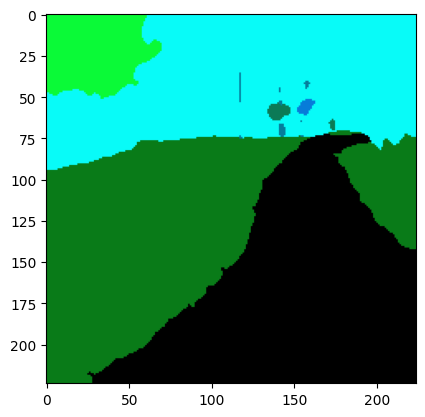

In [43]:
plt.imshow(final_image)

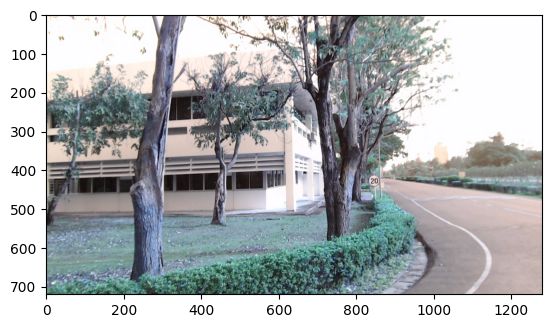

In [11]:
plt.imshow(img2)

In [55]:
upsampled_segmentation = np.resize(outputs[0], (1280, 720))

In [56]:
upsampled_segmentation

array([[4, 4, 4, ..., 4, 4, 4],
       [4, 4, 4, ..., 4, 4, 4],
       [4, 4, 4, ..., 4, 4, 4],
       ...,
       [4, 4, 4, ..., 4, 4, 4],
       [4, 4, 4, ..., 4, 4, 4],
       [4, 4, 4, ..., 9, 9, 9]], dtype=int64)

In [50]:
resized_output = cv2.resize(outputs[0][0][0],(720, 1280))

error: OpenCV(4.9.0) :-1: error: (-5:Bad argument) in function 'resize'
> Overload resolution failed:
>  - src data type = int64 is not supported
>  - Expected Ptr<cv::UMat> for argument 'src'


# Tensorrt

In [ ]:
from optimum.onnxruntime import ORTModelForSequenceClassification
from transformers import AutoTokenizer

ort_model = ORTModelForSequenceClassification.from_pretrained(
  "philschmid/tiny-bert-sst2-distilled",
  export=True,
  provider="CUDAExecutionProvider",
)

tokenizer = AutoTokenizer.from_pretrained("philschmid/tiny-bert-sst2-distilled")
inputs = tokenizer("expectations were low, actual enjoyment was high", return_tensors="pt", padding=True)

outputs = ort_model(**inputs)
assert ort_model.providers == ["CUDAExecutionProvider", "CPUExecutionProvider"]